<h2 align="center">Logistic Regression: A Sentiment Analysis Case Study</h2>

### Introduction
___

- IMDB movie reviews dataset
- http://ai.stanford.edu/~amaas/data/sentiment
- Contains 25000 positive and 25000 negative reviews
<img src="https://i.imgur.com/lQNnqgi.png" align="center">
- At least 7 stars out of 10 $\rightarrow$ positive (label = 1)
- At most 4 stars out of 10 $\rightarrow$ negative (label = 0)
- 50/50 train/test split
- Evaluation accuracy

<b>Features: bag of 1-grams with TF-IDF values</b>:
- Extremely sparse feature matrix - close to 97% are zeros

 <b>Model: Logistic regression</b>
- $p(y = 1|x) = \sigma(w^{T}x)$
- Linear classification model
- Can handle sparse data
- Fast to train
- Weights can be interpreted
<img src="https://i.imgur.com/VieM41f.png" align="center" width=500 height=500>

### Loading the dataset
---

In [1]:
import pandas as pd
df = pd.read_csv('movie_data.csv')
df.head(10)

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0
5,Leave it to Braik to put on a good show. Final...,1
6,Nathan Detroit (Frank Sinatra) is the manager ...,1
7,"To understand ""Crash Course"" in the right cont...",1
8,I've been impressed with Chavez's stance again...,1
9,This movie is directed by Renny Harlin the fin...,1


When the Sentiment is 1, the reviewer likes the movie. When the Sentiment is 0, the reviewer hates the movie.

## Exploratory Data Analysis

Let's check out some of the stats with some plots and the built-in methods in pandas!

In [2]:
df.describe()

,sentiment
count,50000.000000
mean,0.500000
std,0.500005
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [3]:
df.groupby('sentiment').describe()

review                                                            \
           count unique                                                top   
sentiment                                                                    
0          25000  24698  You do realize that you've been watching the E...   
1          25000  24884  Loved today's show!!! It was a variety and not...   

                
          freq  
sentiment       
0            3  
1            5

In [4]:
df['length'] = df['review'].apply(len)
df.head()

,review,sentiment,length
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1,1393
1,OK... so... I really like Kris Kristofferson a...,0,1257
2,"***SPOILER*** Do not read this, if you think a...",0,1678
3,hi for all the people who have seen this wonde...,1,381
4,"I recently bought the DVD, forgetting just how...",0,698


In [5]:
df['review'][0]

'In 1974, the teenager Martha Moxley (Maggie Grace) moves to the high-class area of Belle Haven, Greenwich, Connecticut. On the Mischief Night, eve of Halloween, she was murdered in the backyard of her house and her murder remained unsolved. Twenty-two years later, the writer Mark Fuhrman (Christopher Meloni), who is a former LA detective that has fallen in disgrace for perjury in O.J. Simpson trial and moved to Idaho, decides to investigate the case with his partner Stephen Weeks (Andrew Mitchell) with the purpose of writing a book. The locals squirm and do not welcome them, but with the support of the retired detective Steve Carroll (Robert Forster) that was in charge of the investigation in the 70\'s, they discover the criminal and a net of power and money to cover the murder.<br /><br />"Murder in Greenwich" is a good TV movie, with the true story of a murder of a fifteen years old girl that was committed by a wealthy teenager whose mother was a Kennedy. The powerful and rich famil

In the last sentence, the reviewer has mentioned that his vote is a seven, which means the reviewer has liked the movie and thus falls under positive category.

### Data Visualization
Let's visualize this! Let's do the imports:

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

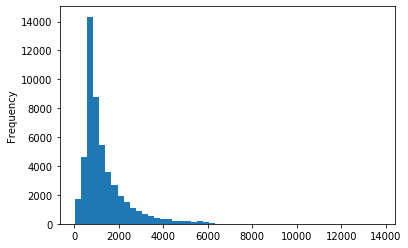

In [7]:
df['length'].plot(bins=50, kind='hist')

In [8]:
df.length.describe()

count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: length, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000027DCF0409C8>,
      dtype=object)

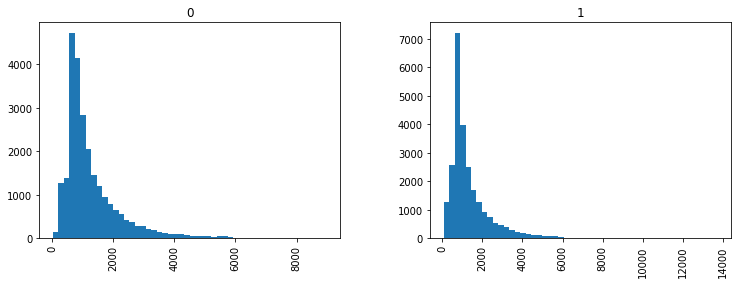

In [9]:
df.hist(column='length', by='sentiment', bins=50,figsize=(12,4))

In [10]:
df.groupby('sentiment').mean()

,length
sentiment,
0,1294.06436
1,1324.79768


Through just basic EDA we've been able to discover a trend that positive reviews tend to have more characters.

## Text Pre-processing
<h2 align="center">Bag of words / Bag of N-grams model</h2>

### Transforming documents into feature vectors

Below, we will call the fit_transform method on CountVectorizer. This will construct the vocabulary of the bag-of-words model and transform the following three sentences into sparse feature vectors:

Sample text:

1. The sun is shining
2. The weather is sweet
3. The sun is shining, the weather is sweet, and one and one is two


In [11]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer()

docs = np.array(['The sun is shining',
                 'The weather is sweet',
                 'The sun is shining, the weather is sweet, and one and one is two'])

bag = count.fit_transform(docs)

In [12]:
print(count.vocabulary_)

{'the': 6, 'sun': 4, 'is': 1, 'shining': 3, 'weather': 8, 'sweet': 5, 'and': 0, 'one': 2, 'two': 7}


**The vocabulary is stored in a python dictionary which maps the unique words in the documents to the unique integer indeces.**

In [13]:
print(bag.toarray())

[[0 1 0 1 1 0 1 0 0]
 [0 1 0 0 0 1 1 0 1]
 [2 3 2 1 1 1 2 1 1]]


**Each index position in the feature vector corresponds to the integer values that are stored in the dictionary items. For example, the first position in the feature vector 0 corresponds to 'and' which only occurs in the last document.**

Raw term frequencies: *tf (t,d)*—the number of times a term t occurs in a document *d*

### Word relevancy using term frequency-inverse document frequency

$$\text{tf-idf}(t,d)=\text{tf (t,d)}\times \text{idf}(t,d)$$

$$\text{idf}(t,d) = \text{log}\frac{n_d}{1+\text{df}(d, t)},$$

where $n_d$ is the total number of documents, and df(d, t) is the number of documents d that contain the term t.

In [14]:
from sklearn.feature_extraction.text import TfidfTransformer
np.set_printoptions(precision=2)
tfidf = TfidfTransformer(use_idf=True,norm='l2',smooth_idf=True)

In [15]:
print(tfidf.fit_transform(count.fit_transform(docs)).toarray())

[[0.   0.43 0.   0.56 0.56 0.   0.43 0.   0.  ]
 [0.   0.43 0.   0.   0.   0.56 0.43 0.   0.56]
 [0.5  0.45 0.5  0.19 0.19 0.19 0.3  0.25 0.19]]


The text data is converted numerically and weighted according to the frequency in each sentence.

The equations for the idf and tf-idf that are implemented in scikit-learn are:

$$\text{idf} (t,d) = log\frac{1 + n_d}{1 + \text{df}(d, t)}$$
The tf-idf equation that is implemented in scikit-learn is as follows:

$$\text{tf-idf}(t,d) = \text{tf}(t,d) \times (\text{idf}(t,d)+1)$$

### Data Preparation

In [16]:
df.loc[0, 'review'][-50:]
#prints the last 50 characters of the first review.

'is seven.<br /><br />Title (Brazil): Not Available'

The text consists of punctuations, HTML tags and Emoticons. 

In [17]:
import re
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    return text

In [18]:
preprocessor(df.loc[0, 'review'][-50:])
#The punctuations and the HTML tags will be removed. 

'is seven title brazil not available'

In [19]:
df['review'] = df['review'].apply(preprocessor)

In [20]:
df['review'][100]
#Checking a random review from the dataset

'ordinarily i really enjoy movies like chances are but i wasn t quite satisfied with this one for a few reasons the first half was pretty well done overall with alex finch dying and being reincarnated in a new body played by robert downey jr he meets up with his wife cybill shepherd and friend ryan o neal and his daughter who is now grown up the scenes with them meeting again and downey rediscovering who he once was are well done and there is a good amount of emotion and happiness once shepherd finally believes its really her husband reincarnated but from there the film goes downhill there are several sex related scenes that turned me off completely especially downey and shepherd wanting to get together again despite the difference in their age now after that however the film manages to end in the most satisfying way possible considering the circumstances of the plot i was disappointed because i did not expect the film to become so immoral by the end there was great potential with this

### Tokenization of documents

<h4>Stemming</h4>
<br>
Stemming is the process of producing morphological variants of a root/base word. Stemming programs are commonly referred to as stemming algorithms or stemmers. A stemming algorithm reduces the words “chocolates”, “chocolatey”, “choco” to the root word, “chocolate” and “retrieval”, “retrieved”, “retrieves” reduce to the stem “retrieve”.

In [21]:
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

In [22]:
def tokenizer(text):
    return text.split()

In [23]:
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

Example :

In [24]:
text = "Runners like running and they run a lot"

In [25]:
tokenizer(text)

['Runners', 'like', 'running', 'and', 'they', 'run', 'a', 'lot']

In [26]:
tokenizer_porter(text)

['runner', 'like', 'run', 'and', 'they', 'run', 'a', 'lot']

In [27]:
from nltk.corpus import stopwords

In [28]:
stop = stopwords.words('english')
[w for w in tokenizer_porter(text)[-10:] if w not in stop]

['runner', 'like', 'run', 'run', 'lot']

### Transform Text Data into TF-IDF Vectors

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(strip_accents = None,
                       lowercase = False,
                       preprocessor = None,
                       tokenizer = tokenizer_porter,
                       use_idf = True,
                       norm = 'l2',
                       smooth_idf = True)


In [30]:
y = df.sentiment.values
X = tfidf.fit_transform(df.review)

### Document Classification using Logistic Regression

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=1,test_size=0.5,shuffle=False)

In [33]:
import pickle
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(cv=5,
                          scoring='accuracy',
                          random_state=0,
                          n_jobs=-1,
                          verbose=3,
                          max_iter=300).fit(X_train,y_train)

saved_model = open('saved_model.sav','wb')
pickle.dump(clf,saved_model)
saved_model.close()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.8min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


### Model Evaluation

In [34]:
filename = 'saved_model.sav'
saved_clf = pickle.load(open(filename,'rb'))

In [37]:
saved_clf.score(X_test,y_test)

0.89608

In [38]:
accuracy = round((saved_clf.score(X_test,y_test)*100),3)

In [39]:
print("An accuracy of",accuracy,"% is achieved.")

An accuracy of 89.608 % is achieved.


<h2>Work Summary: </h2>

1. The dataset is loaded.
2. Exploratory data analysis is performed. It is found that positive reviews tend to be longer than negative review.
3. Data Visualization is performed.
4. Punctuations and HTML tags are removed from the text data.
5. Stemming is performed to reduce the words to its rootwords. 
6. Stopwords (such as 'and', 'so') are removed.
6. The raw text (sequence of characters) is converted into vectors (sequence of numbers).
7. Text Data is transformed into TF-IDF Vectors.
8. The data is splitted into train and test set.
9. Logistic Regression is performed.
10. The accuracy is computed.
